# New York City Taxi Analysis
---

### Introduction

This notebook shows you how we can use exploratory data analysis and machine learning for predicting breast cancers. All our models are built using  New York City Taxi dataset.

### Loading Necessary Tools (Python/Numpy, Pandas, Scikit-Learn, LGBM, and etc.) 

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

print('Numpy version: {}'.format(np.__version__))
print('Pandas version: {}'.format(pd.__version__))
print('Light Gradient Booting version: {}'.format(lgb.__version__))

%matplotlib inline

Numpy version: 1.12.1
Pandas version: 0.19.2
Light Gradient Booting version: 2.1.0


### Loading the Dataset

Next, we are going to load the dataset as a Pandas data frame (DataFrame). In ML model building, it is the best practice to keep the testing dataset aside and it should not be mixed with training dataset. So as the very first step, we split our dataset into training and testing subsets.

We are going to use **80 percent** (i.e. **8000 data rows**) of the dataset for training and the rest (i.e. **2000 data rows**) for testing. 

In [2]:
data = pd.read_csv('./data/yellow_tripdata_2016-01_10000rows.csv')
data = data.sample(n=len(data))

train_size = int(len(data)*0.8)
test_size = len(data) - train_size

assert len(data) == (train_size + test_size)
print('training dataset size: {}'.format(train_size))
print('testing dataset size: {}'.format(test_size))

train = data.iloc[0:train_size]
test = data.iloc[train_size:]

assert len(data) == len(train) + len(test)

training dataset size: 8000
testing dataset size: 2000


As you know real-world datasets come with missing values  (or measurements). So, first of all, we need to check this dataset contains null or missing values. If it has missing values, proper data imputation techniques need to be applied.

I'm going to use **Panda's** **`isnull()`** for testing null/missing values.

In [3]:
assert train.isnull().values.any() == False
assert test.isnull().values.any() == False

Great, this dataset doesn't have any missing values so we don't need to use data imputation techniques. If it contains missing values I might be using one or more following techniques.

1. **Impute missing values with mean**: Usually, this is suitable for numerical features.
2. **Impute missing values with median**: This approach is more appropriate for categorical features.
3. **EM algorithm based approaches**: Bit advanced but very useful tool for missing value imputation.

### Create Response Variable

In this analysis, we are going to predict taxi trip duration using available data. So we create our response variable using **tpep_pickup_datetime** and **tpep_dropoff_datetime**.

In [4]:
from datetime import datetime

fmt = '%m/%d/%Y %H:%M'

def calculate_trip_duration(row):
    start = datetime.strptime(row['tpep_pickup_datetime'], fmt)
    end = datetime.strptime(row['tpep_dropoff_datetime'], fmt)
    return (end - start).seconds / 60.0

train['trip_time'] = train.apply(calculate_trip_duration, axis=1)
test['trip_time'] = test.apply(calculate_trip_duration, axis=1)

/home/upul/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/upul/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
5048,1,1/16/2016 2:23,1/16/2016 2:30,2,1.90,-73.977722,40.786709,1,N,-73.953400,40.788414,1,8.0,0.5,0.5,1.40,0.00,0.3,10.70
8015,1,1/26/2016 15:08,1/26/2016 15:29,2,1.50,-73.985901,40.759048,1,N,-73.980957,40.744484,1,13.0,0.0,0.5,0.20,0.00,0.3,14.00
5622,1,1/17/2016 18:14,1/17/2016 18:16,1,0.70,-73.931282,40.765610,1,N,-73.924240,40.774410,1,4.0,0.0,0.5,1.20,0.00,0.3,6.00
8352,2,1/27/2016 15:07,1/27/2016 15:18,1,0.93,-73.982727,40.742622,1,N,-73.985329,40.731949,1,7.5,0.0,0.5,1.66,0.00,0.3,9.96
9417,1,1/30/2016 11:12,1/30/2016 11:18,1,1.20,-73.966415,40.794521,1,N,-73.952385,40.789845,2,6.5,0.0,0.5,0.00,0.00,0.3,7.30
4502,2,1/14/2016 17:50,1/14/2016 17:55,5,0.78,-73.950119,40.780060,1,N,-73.957466,40.770340,1,5.0,1.0,0.5,0.50,0.00,0.3,7.30
2136,2,1/7/2016 20:18,1/7/2016 20:28,1,1.34,-73.974762,40.790859,1,N,-73.976784,40.775269,1,8.5,0.5,0.5,1.96,0.00,0.3,11.76
2765,2,1/9/2016 15:28,1/9/2016 15:33,1,1.32,-73.990120,40.668835,1,N,-74.005440,40.653469,2,6.5,0.0,0.5,0.00,0.00,0.3,7.30
122,1,1/1/2016 6:49,1/1/2016 6:57,1,1.70,-73.965813,40.795353,1,N,-73.946976,40.780838,2,8.5,0.0,0.5,0.00,0.00,0.3,9.30
1962,1,1/7/2016 11:40,1/7/2016 11:48,1,2.50,-73.979919,40.720558,1,N,-74.004288,40.707336,1,10.0,0.0,0.5,2.15,0.00,0.3,12.95


### Exploratory Data Analysis and Visualization

Exploratory data analysis helps us to understand the nature of the training dataset. Also, it is a great tool to understand the relationships between different features of the dataset.

### Distribution of  Response Variable (Taxi Trip Duration)

As the first step of our exploratory data analysis, we plot the distribution of taxi trip durations measured in minutes. 

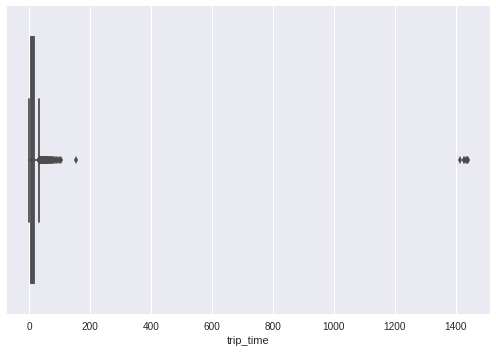

In [6]:
f, axes = plt.subplots(1, 1)
f.set_size_inches(7, 5)

sns.boxplot(train['trip_time'])
plt.tight_layout()
plt.show()

Above graph clearly shows we have few **outliers**. So let's remove those and redraw the graph again. 

In [7]:
train = train.drop(train[train.trip_time > 120].index)
test = test.drop(test[test.trip_time > 120].index)

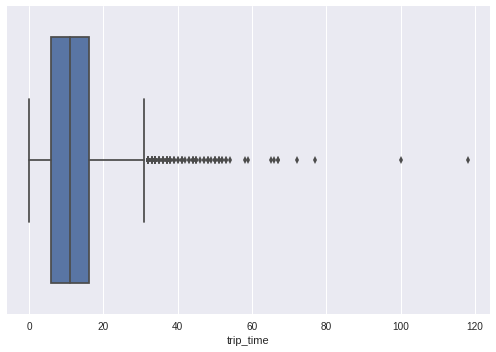

In [8]:
f, axes = plt.subplots(1, 1)
f.set_size_inches(7, 5)

sns.boxplot(test['trip_time'])
plt.tight_layout()
plt.show()

Now response variables look OK.

### Various Plots to Identify Good Features and Relationship Between Features

We can use the following three plots to identify quality (in terms of predictive power) features for our model building process. Also, it is worth to note that, for real-world projects, we might use a lot more plots and visualizations than we presented in this notebook.

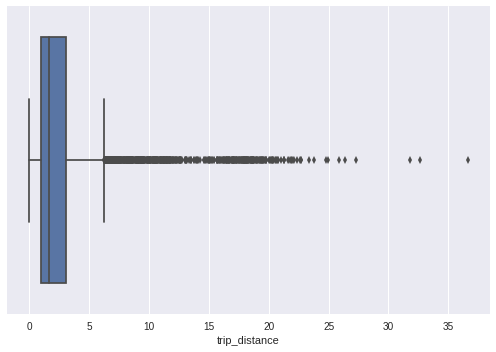

In [9]:
f, axes = plt.subplots(1, 1)
f.set_size_inches(7, 5)

sns.boxplot(train['trip_distance'])
plt.tight_layout()
plt.show()

In [10]:
data.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
5048,1,1/16/2016 2:23,1/16/2016 2:30,2,1.90,-73.977722,40.786709,1,N,-73.953400,40.788414,1,8.0,0.5,0.5,1.40,0.0,0.3,10.70
8015,1,1/26/2016 15:08,1/26/2016 15:29,2,1.50,-73.985901,40.759048,1,N,-73.980957,40.744484,1,13.0,0.0,0.5,0.20,0.0,0.3,14.00
5622,1,1/17/2016 18:14,1/17/2016 18:16,1,0.70,-73.931282,40.765610,1,N,-73.924240,40.774410,1,4.0,0.0,0.5,1.20,0.0,0.3,6.00
8352,2,1/27/2016 15:07,1/27/2016 15:18,1,0.93,-73.982727,40.742622,1,N,-73.985329,40.731949,1,7.5,0.0,0.5,1.66,0.0,0.3,9.96
9417,1,1/30/2016 11:12,1/30/2016 11:18,1,1.20,-73.966415,40.794521,1,N,-73.952385,40.789845,2,6.5,0.0,0.5,0.00,0.0,0.3,7.30


### Exploratory Data Analysis and Visualization

Exploratory data analysis helps us to understand the nature of the training dataset. Also, it is a great tool to understands the relationships between different features of the dataset.

#### Scatter Plot: Pickup Points

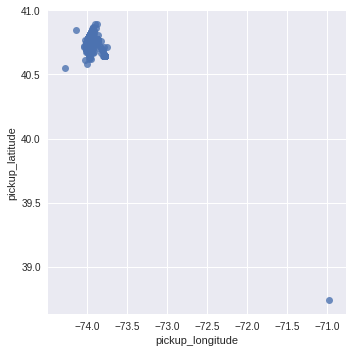

In [11]:
sns.lmplot('pickup_longitude', 'pickup_latitude', 
           data=train, fit_reg=False)    
plt.tight_layout()
plt.show()

#### Scatter Plot: Pickup Points

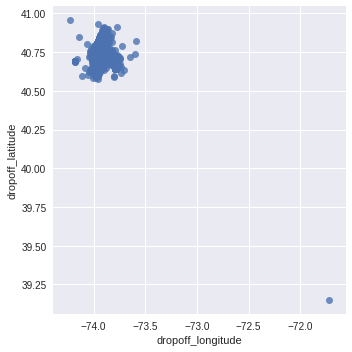

In [12]:
sns.lmplot('dropoff_longitude', 'dropoff_latitude', data=train, fit_reg=False)
plt.tight_layout()
plt.show()

So it looks like we have few outliers based on the longitude and altitude data. So let's further clean our dataset.  

In [21]:
cond_1 = (train.dropoff_longitude > -73.5) 
cond_2 = (train.dropoff_latitude < 40.5 )
train = train.drop(train[cond_1 & cond_2].index)

cond_3 = (train.dropoff_longitude > -73.5) 
cond_4 = (train.dropoff_latitude < 40.5 )
train = train.drop(train[cond_3 & cond_4].index)

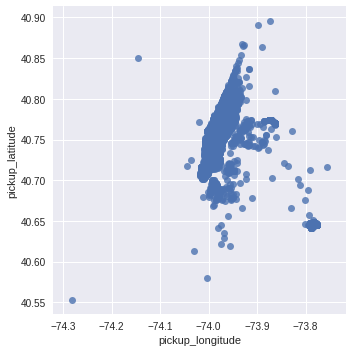

In [25]:
sns.lmplot('pickup_longitude', 'pickup_latitude', 
           data=train, fit_reg=False)    
plt.tight_layout()
plt.show()

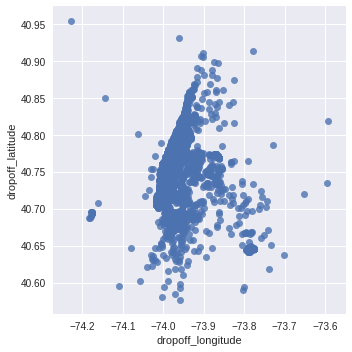

In [20]:
sns.lmplot('dropoff_longitude', 'dropoff_latitude', data=train, fit_reg=False)
plt.tight_layout()
plt.show()

Great, now data looks OK in terms of longitudes and altitudes 

In [14]:
https://github.com/Currie32/NYC-Taxi-Trip-Duration/blob/master/notebook.ipynb
https://github.com/Kulbear/New-York-City-Taxi-Trip-Duration/blob/master/xgboost.ipynb
https://github.com/Kulbear/New-York-City-Taxi-Trip-Duration/blob/master/xgboost.ipynb
https://github.com/yennanliu/NYC_Taxi_Trip_Duration/blob/master/notebook/EDA_jtsai_DensPixels.ipynb
https://github.com/yennanliu/NYC_Taxi_Trip_Duration/blob/master/notebook/NYC_Taxi_EDA_V1_Yen.ipynb

SyntaxError: invalid syntax (<ipython-input-14-d3ddc0b559eb>, line 1)